# Projet de simulation

---



In [13]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

In [14]:
import warnings
warnings.filterwarnings('ignore')

## Question 1 :

On commence par définir des fonctions pour la simulation des paramètres du modèle et le calcul des constantes du système d'équations différentielles

In [15]:
def get_params(): #Simulation des paramètres
    p_a = np.random.uniform(0.4,0.9)
    p_ih = np.random.uniform(0.05,0.2)
    p_iu = np.random.uniform(0.01,0.04)
    p_hd = np.random.uniform(0.1,0.2)
    p_hu = np.random.uniform(0.1,0.2)
    p_ud = np.random.uniform(0.2,0.4)
    n_i = np.random.randint(8,12)
    n_h = np.random.randint(15,25)
    n_u = np.random.randint(10,20)
    r0 = np.random.uniform(2.9,3.4)
    mu = np.random.uniform(0.01,0.08)
    n = np.random.randint(30,50)
    t0 = np.random.randint(0,30) #On définit t0 comme le nombre de jours après la date initiale, ainsi t0 est tiré uniformément entre le 25/01 et le 24/02
    i0 = np.random.randint(1,100)
    l1 = np.random.uniform(10e-4,10e-3)
    l2 = 0

    return p_a , p_ih , p_iu , p_hd , p_hu , p_ud , n_i , n_h , n_u , r0 , mu , n , t0 , i0 , l1 , l2



def prepare_pars(p_a , p_ih , p_iu , p_hd , p_hu , p_ud , n_i , n_h , n_u , r0 , mu , n , t0 , i0 , l1 , l2):
#Calcul des constantes du système
    g_IR = (p_a + (1-p_a)*(1-p_ih-p_iu))/n_i
    g_IH = (1-p_a)*p_ih/n_i
    g_IU = (1-p_a)*p_iu/n_i
    g_HD = p_hd/n_h
    g_HU = p_hu/n_h
    g_HR = (1 - p_hd - p_hu)/n_h
    g_UD = p_ud/n_u
    g_UR = (1 - p_ud)/n_u
    S0 = 67e6
    Y0 = np.zeros(10)
    Y0[0] = 67e6
    Y0[1] = i0

    tau0 = r0*(l1 + g_IR + g_IH + g_IU)/S0

    return g_IR , g_IH , g_IU , g_HD , g_HU , g_HR , g_UD , g_UR , S0 , tau0 , Y0

p_a , p_ih , p_iu , p_hd , p_hu , p_ud , n_i , n_h , n_u , r0 , mu , n , t0 , i0 , l1 , l2 = get_params()
g_IR , g_IH , g_IU , g_HD , g_HU , g_HR , g_UD , g_UR , S0 , tau0 , Y0 = prepare_pars(p_a , p_ih , p_iu , p_hd , p_hu , p_ud , n_i , n_h , n_u , r0 , mu , n , t0 , i0 , l1 , l2)

In [16]:
def tau(t , tau0 , n , mu): #On définit le taux de transmission
    return tau0*np.exp(-mu*max((t-n) , 0))

In [17]:
from scipy.integrate import solve_ivp

On définit le système d'équations différentielles régissant l'évolution de l'épidémie.

In [18]:
def systeme(t , Y , l1 , l2 , g_IR , g_IH , g_IU , g_HD , g_HU , g_HR , g_UD , g_UR , tau0 , n , mu):

    S = Y[0]
    Im = Y[1]
    Ip = Y[2]
    Rm = Y[3]
    RpI = Y[4]
    H = Y[5]
    U = Y[6]
    RpH = Y[7]
    D = Y[8]
    DR = Y[9]


    dS_dt = -tau(t , tau0 , n , mu)*S*Im
    dIm_dt = tau(t , tau0 , n , mu)*S*Im - l1*Im - (g_IR + g_IH + g_IU)*Im
    dIp_dt = l1*Im - (g_IR + g_IH + g_IU)*Ip
    dRm_dt = g_IR*Im - l2*Rm
    dRpI_dt = g_IR*Ip + l2*Rm
    dH_dt = g_IH*(Im + Ip) - (g_HR + g_HU + g_HD)*H
    dU_dt = g_IU*(Im + Ip) + g_HU*H - (g_UR + g_UD)*U
    dRpH_dt = g_HR*H + g_UR*U
    dD_dt = g_HD*H + g_UD*U
    dDR_dt = (l1 + g_IH + g_IU)*Im - DR #Définition du compartiment supplémentaire DR

    return [dS_dt , dIm_dt , dIp_dt , dRm_dt , dRpI_dt , dH_dt , dU_dt , dRpH_dt , dD_dt , dDR_dt]

In [19]:
p_a , p_ih , p_iu , p_hd , p_hu , p_ud , n_i , n_h , n_u , r0 , mu , n , t0 , i0 , l1 , l2 = get_params()

g_IR , g_IH , g_IU , g_HD , g_HU , g_HR , g_UD , g_UR , S0 , tau0, Y0 = prepare_pars(p_a , p_ih , p_iu , p_hd , p_hu , p_ud , n_i , n_h , n_u , r0 , mu , n , t0 , i0 , l1 , l2)

args = (l1 , l2 , g_IR , g_IH , g_IU , g_HD , g_HU , g_HR , g_UD , g_UR , tau0 , n , mu)

On résout le sysyème :

In [20]:
solution = solve_ivp(lambda t,y : systeme(t , y , *args) , [t0, t0 + 130], Y0,  method='RK45')

In [21]:
columns = ['S' , 'Im' , 'Ip' , 'Rm' , 'RpI' , 'H' , 'U' , 'RpH' , 'D' , 'DR']
results = pd.DataFrame(solution.y.T , columns = columns)

In [22]:
from random import randrange
from datetime import timedelta
from datetime import datetime

#On transforme l'entier t0 en un objet datetime
t0 = datetime(day = 25 , month = 1 , year = 2020) + timedelta(days = t0)
N = datetime(day = 24 , month = 2 , year = 2020) + timedelta(days = n)

In [23]:
index = pd.date_range(start = t0 ,  periods=len(results)).date
results.index = index

Traçons les courbes obtenues pour les compartiments H, U, D et DR

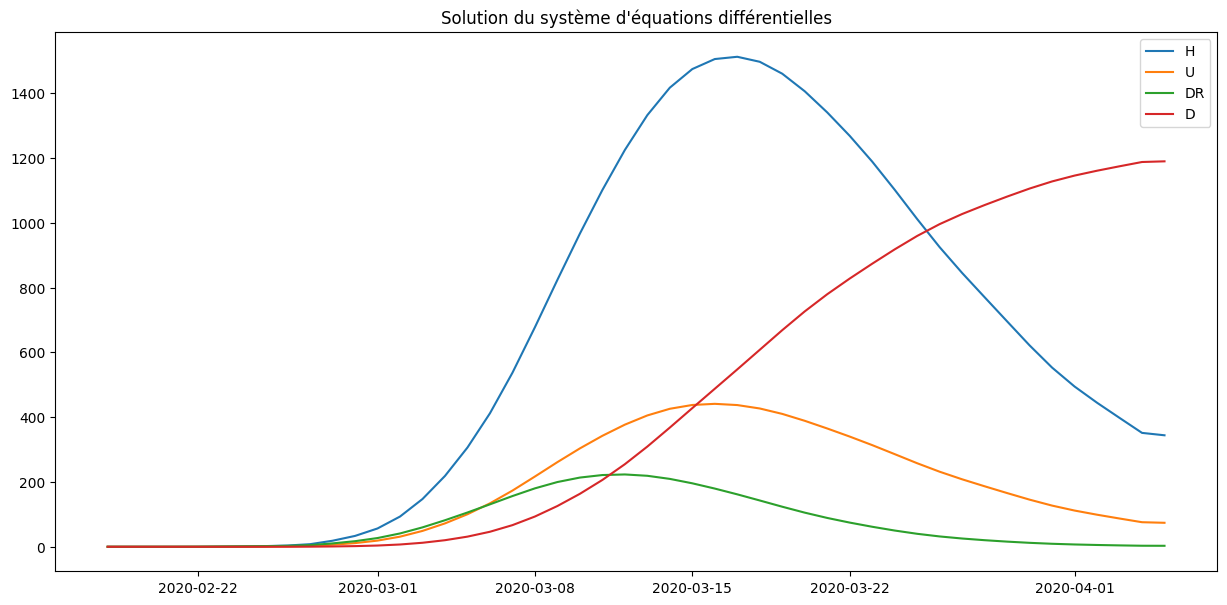

In [24]:
plt.figure(figsize=(15,7))
results.H.plot(label = 'H')
results.U.plot(label = 'U')
results.DR.plot(label = 'DR')
results.D.plot(label = 'D')
plt.legend()
plt.title("Solution du système d'équations différentielles")
plt.show()

In [25]:
print('Le' , results.U.argmax() ,int(results.U.max()) , 'patients en réanimation.')

Le 27 441 patients en réanimation.


Le nombre maximal de patients en soins intensifs atteint pour cette simulation est de 74, ce nombre est atteint le 20 février 2020

## Question 2 :

On procède par échantillonnage de Monte Carlo pour déterminer la loi du pic de patients en soins intensifs et de la date de ce pic

In [26]:
max_rea = [] #Liste pour stocker les maximum de patients en soins intensifs
date_max = [] #Liste pour stocker la date du pic
for i in tqdm(range(100)):
    p_a , p_ih , p_iu , p_hd , p_hu , p_ud , n_i , n_h , n_u , r0 , mu , n , t0 , i0 , l1 , l2 = get_params()
    g_IR , g_IH , g_IU , g_HD , g_HU , g_HR , g_UD , g_UR , S0 , tau0, Y0 = prepare_pars(p_a , p_ih , p_iu , p_hd , p_hu , p_ud , n_i , n_h , n_u , r0 , mu , n , t0 , i0 , l1 , l2)
    args = (l1 , l2 , g_IR , g_IH , g_IU , g_HD , g_HU , g_HR , g_UD , g_UR , tau0 , n , mu)
    solution = solve_ivp(lambda t , y : systeme(t , y , *args) , [t0, t0 + 130], Y0, method='RK45', max_step=1)
    results = pd.DataFrame(solution.y.T , columns = columns)
    t0 = datetime(day = 25 , month = 1 , year = 2020) + timedelta(days = t0)
    index = pd.date_range(start = t0 ,  periods=len(results))
    results.index = index
    max_rea.append(results['U'].max())
    date_max.append(results.index[results['U'].argmax()])

  0%|          | 0/100 [00:00<?, ?it/s]

On calcule la moyenne et les quantiles à 10 et 90% pour les deux variables d'intérêt, dont on trace les histogrammes

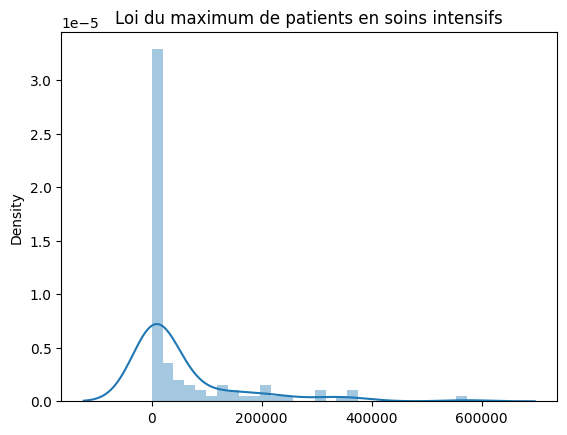

Moyenne : 55530.92006552096
Quantile 10% : 104.7498472983362
Quantile 90% : 204116.03535493926


In [27]:
max_rea = pd.Series(max_rea)
sns.distplot(max_rea)
plt.title('Loi du maximum de patients en soins intensifs')
plt.show()
print('Moyenne :' , max_rea.mean())
print('Quantile 10% :' , max_rea.quantile(0.1))
print('Quantile 90% :' , max_rea.quantile(0.9))

Moyenne : 61.9
Pic en moyenne atteint le:  2020-04-21
Quantile 10% : 43.0
Quantile 90% : 85.10000000000001


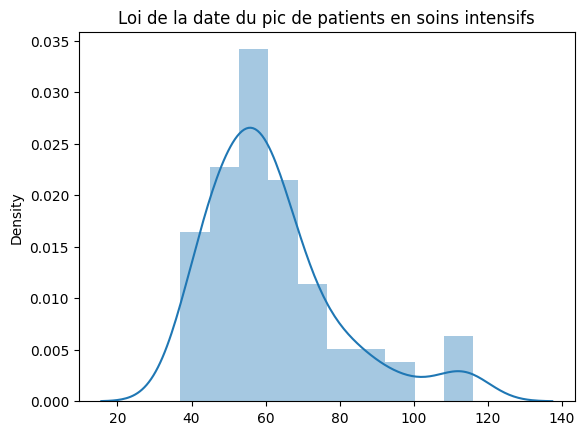

In [28]:
Max_day = (pd.Series(date_max) - t0).dt.days
print('Moyenne :' , Max_day.mean())
print('Pic en moyenne atteint le: ' , (t0 + timedelta(days = int(Max_day.mean()))).date())
print('Quantile 10% :' , Max_day.quantile(0.1))
print('Quantile 90% :' , Max_day.quantile(0.9))
sns.distplot(Max_day)
plt.title('Loi de la date du pic de patients en soins intensifs')
plt.show()

## Analyse de sensibilité qualitative :

On commence par mener une analyse de sensibilité qualitative par une méthode de Morris sur les variables Max de patients en soins intensifs et date du pic en soins intensifs, que l'on désignera par "Variable Max" et "Variable Date"

### Variable Max

In [29]:
R = 100 #On choisit de mener notre analyse sur 100 simulations
X = np.zeros((R , 16))
for i in tqdm(range(R)):
    X[i] = list(get_params()) #Simulation de 100 vecteurs de paramètres, stockés dans une variable X

  0%|          | 0/100 [00:00<?, ?it/s]

La fonction d'intérêt ici est une fonction qui prend en entrée une réalisation des paramètres et renvoie le maximum de patients en soins intensifs, calculés avec ces paramètres.

In [30]:
def f_max(params): #Définition de la fonction renvoyant la variable Max
    p_a , p_ih , p_iu , p_hd , p_hu , p_ud , n_i , n_h , n_u , r0 , mu , n , t0 , i0 , l1 , l2 = tuple(params)
    g_IR , g_IH , g_IU , g_HD , g_HU , g_HR , g_UD , g_UR , S0 , tau0, Y0 = prepare_pars(p_a , p_ih , p_iu , p_hd , p_hu , p_ud , n_i , n_h , n_u , r0 , mu , n , t0 , i0 , l1 , l2)
    args = (l1 , l2 , g_IR , g_IH , g_IU , g_HD , g_HU , g_HR , g_UD , g_UR , tau0 , n , mu)
    solution = solve_ivp(lambda t,y : systeme(t,y,*args) , [t0, t0 + 130], Y0, max_step=1)
    columns = ['S' , 'Im' , 'Ip' , 'Rm' , 'RpI' , 'H' , 'U' , 'RpH' , 'D' , 'DR']
    results = pd.DataFrame(solution.y.T , columns = columns)
    return results['U'].max()

In [31]:
delta = 0.1 #On choisit arbitrairement un delta pour la méthode de Morris

On commence par calculer les différences finies $S_j^{x_k} = \frac{f(x_k + \delta e_j) - f(x_k)}{\delta}$ pour $k = 1,..,R$ et $j = 1,..p$ où $p = 16$

In [32]:
Ss = np.zeros((R , 16)) #Variable de stockage des différences finies
for j in tqdm(range(16)):
    for i in range(R):
        x = X[i]
        x_delta = x.copy()
        x_delta[j]+=delta
        Ss[i , j] = (f_max(x_delta) - f_max(x))/delta

  0%|          | 0/16 [00:00<?, ?it/s]

On calcule les variables $\mu_i$ et $\sigma_i$ pour $i = 1,..,16$

In [33]:
mus = np.zeros(16)
sigmas = np.zeros(16)
for i in tqdm(range(16)):
    mus[i] = np.abs(Ss[: , i]).mean()
    sigmas[i] = np.sqrt(sum((Ss[k , i] - np.mean([Ss[:,i]]))**2 for k in range(R))/(R-1))

  0%|          | 0/16 [00:00<?, ?it/s]

In [34]:
variables = variables = ['p_a' , 'p_ih' , 'p_iu' , 'p_hd' , 'p_hu' , 'p_ud' , 'n_i' , 'n_h' , 'n_u' , 'r0' , 'mu' , 'n' , 't0' , 'i0' , 'l1' , 'l2']
pd.DataFrame(np.array([variables , mus ,sigmas]).T , columns = ['Variable' , 'Mu' , 'Sigma'])

,Variable,Mu,Sigma
0,p_a,116382.51730430652,193890.8261668968
1,p_ih,122665.7234801588,230988.18337266534
2,p_iu,1140696.0611773478,2095341.3423340274
3,p_hd,0.003423288354837095,0.014526560251139521
4,p_hu,113631.9717981097,228897.49961063924
5,p_ud,0.0013022363539424652,0.005790753680256028
6,n_i,19563.56387157809,29143.88913490499
7,n_h,440.8030992865626,959.9522706060612
8,n_u,2163.3324056207357,4345.704013101209
9,r0,98103.86694938973,137968.9511713664


En inspectant les résultats de l'analyse de sensibilité, on remarque par exemple que les variables $p_{hd}$ et $p_{ud}$ semblent être à effets négligeables sur la variable Max lorsque $p_a$, $p_{ih}$ ou $p_{iu}$ semblent avoir des effets non linéaires avec intéraction

## Variable date

On réitère l'étude pour la variable Date

In [35]:
def f_date(params): #Définition de la fonction renvoyant la date du pic de patients en soins intensifs
    p_a , p_ih , p_iu , p_hd , p_hu , p_ud , n_i , n_h , n_u , r0 , mu , n , t0 , i0 , l1 , l2 = tuple(params)
    g_IR , g_IH , g_IU , g_HD , g_HU , g_HR , g_UD , g_UR , S0 , tau0, Y0 = prepare_pars(p_a , p_ih , p_iu , p_hd , p_hu , p_ud , n_i , n_h , n_u , r0 , mu , n , t0 , i0 , l1 , l2)
    args = (l1 , l2 , g_IR , g_IH , g_IU , g_HD , g_HU , g_HR , g_UD , g_UR , tau0 , n , mu)
    solution = solve_ivp(lambda t,y : systeme(t , y , *args), [t0, t0 + 130], Y0, max_step=1)

    columns = ['S' , 'Im' , 'Ip' , 'Rm' , 'RpI' , 'H' , 'U' , 'RpH' , 'D' , 'DR']
    results = pd.DataFrame(solution.y.T , columns = columns)

    return results['U'].argmax()

In [36]:
delta = 0.1
Ss = np.zeros((R , 16))
for j in tqdm(range(16)):
    mu = 0
    sigma = 0
    for i in range(R):
        x = X[i]
        x_delta = x.copy()
        x_delta[j]+=delta
        Ss[i , j] = (f_date(x_delta) - f_date(x))/delta

  0%|          | 0/16 [00:00<?, ?it/s]

In [37]:
mus = np.zeros(16)
sigmas = np.zeros(16)
for i in tqdm(range(16)):
    mus[i] = np.abs(Ss[: , i]).mean()
    sigmas[i] = np.sqrt(sum((Ss[k , i] - np.mean([Ss[:,i]]))**2 for k in range(R))/(R-1))

variables = ['p_a' , 'p_ih' , 'p_iu' , 'p_hd' , 'p_hu' , 'p_ud' , 'n_i' , 'n_h' , 'n_u' , 'r0' , 'mu' , 'n' , 't0' , 'i0' , 'l1' , 'l2']

pd.DataFrame(np.array([variables , mus ,sigmas]).T , columns = ['Variable' , 'Mu' , 'Sigma']).sort_values('Sigma' , ascending = False)

  0%|          | 0/16 [00:00<?, ?it/s]

,Variable,Mu,Sigma
1,p_ih,23.1,8.250497383231325
4,p_hu,19.1,6.830561152391921
6,n_i,2.5,4.793724854411023
12,t0,0.9,2.93188669562103
11,n,0.5,2.190429135575903
2,p_iu,37.7,19.428969310924575
9,r0,12.4,18.283955543126627
14,l1,202.5,146.56673592875052
10,mu,222.8,141.9566017051578
8,n_u,0.4,1.969463855669325


## Analyse de sensibilité quantitative

Menons cette fois-ci une analyse de sensibilité quantitative par la méthode de Sobol. Nous calculerons pour différentes variables (Max, Date etc.) les indices d'ordre 1 $S_i$ et totaux $S_{T_i}$ de Sobol.

# Variable Max

On commence par simuler deux fois 100 réalisations des paramètres pour former les matrices $X$ et $\tilde{X}$

In [38]:
R = 100 #On choisit de mener l'analyse sur R = 100 simulations
X = np.zeros((R , 16)) #Création de X
Xt = np.zeros((R , 16)) #Création de X_tilde
for i in tqdm(range(R)):
    X[i] = list(get_params())
    Xt[i] = list(get_params())

  0%|          | 0/100 [00:00<?, ?it/s]

Pour préparer le calcul des indices de Sobol, on génère les matrices $X^{(i)} = (X_1 , .. , X_{i-1} , \tilde{X_i} ,X_{i+1}, .. X_p)$ et $\tilde{X}^{(i)} = (\tilde{X}_1 , .. , \tilde{X}_{i-1} , X_i ,\tilde{X}_{i+1}, .. \tilde{X}_p)$

In [39]:
Xs = [] #Matrice X^(i)
Xsp = [] #Matrice X_tilde^(i)
for j in tqdm(range(16)):
    var = Xt.copy()
    var[: , j] = X[: , j]
    varp = X.copy()
    varp[: , j] = Xt[: , j]
    Xs.append(var)
    Xsp.append(varp)

  0%|          | 0/16 [00:00<?, ?it/s]

On calcule les variables $Y$ , $Y_i$ et $\tilde{Y}_i$ pour estimer $f_0$ , $D$, $Cov(Y , Y_i)$ et $Cov(Y,\tilde{Y_i})$

In [40]:
Y = np.array([f_max(X[i]) for i in range(R)]) #Calcul de Y
Ys = np.array([[f_max(Xs[i][k]) for k in range(R)]for i in range(16)]) #Calcul des Y_i
Ysp = np.array([[f_max(Xsp[i][k]) for k in range(R)]for i in range(16)]) #Calcul des Y_tilde_i

In [41]:
f0_h = np.mean(Y)
D = np.mean(Y**2) - f0_h**2

In [42]:
Ds = np.array([np.mean(Y*Ys[i][:]) for i in range(16)]) - f0_h**2 #Indices de Sobol d'ordre 1

In [43]:
pd.DataFrame([variables , Ds/D] , index = ['Paramètre' , 'Indice O1']).T.sort_values('Indice O1' , ascending = False)

,Paramètre,Indice O1
12,t0,0.280834
10,mu,0.258336
6,n_i,0.156322
9,r0,0.110202
11,n,0.100752
2,p_iu,0.054512
14,l1,0.044808
3,p_hd,0.04395
15,l2,0.04395
5,p_ud,0.04395


In [44]:
Dts = [np.mean([(Y[k] - Ysp[i][k])**2 for k in range(R)]) for i in range(16)] #Indices totaux de Sobol

In [45]:
pd.DataFrame([variables , Dts/D] , index = ['Paramètre' , 'Indice total']).T.sort_values('Indice total' , ascending = False)

,Paramètre,Indice total
12,t0,1.082576
10,mu,0.937983
0,p_a,0.635923
6,n_i,0.486561
11,n,0.426839
9,r0,0.20329
2,p_iu,0.146247
13,i0,0.11101
8,n_u,0.046491
1,p_ih,0.034588


# Variable Date

On réitère la même analyse pour la variable date

In [46]:
Y_date = np.array([f_date(X[i]) for i in range(R)])
Ys_date = np.array([[f_date(Xs[i][k]) for k in range(R)]for i in range(16)])
Ysp_date = np.array([[f_date(Xsp[i][k]) for k in range(R)]for i in range(16)])

f0_h = np.mean(Y_date)
D = np.mean(Y_date**2) - f0_h**2

In [47]:
Ds = np.array([np.mean(Y_date*Ys_date[i][:]) for i in range(16)]) - f0_h**2 #Indices de Sobol d'ordre 1
pd.DataFrame([variables , Ds/D] , index = ['Paramètre' , 'Indice O1']).T.sort_values('Indice O1' , ascending = False)

,Paramètre,Indice O1
10,mu,0.907878
13,i0,0.64112
2,p_iu,0.611776
12,t0,0.564787
7,n_h,0.552993
9,r0,0.551566
3,p_hd,0.549806
5,p_ud,0.549806
15,l2,0.549806
0,p_a,0.544242


In [48]:
Dts = [np.mean([(Y_date[k] - Ysp_date[i][k])**2 for k in range(R)]) for i in range(16)] #Indices totaux de Sobol
pd.DataFrame([variables , Dts/D] , index = ['Paramètre' , 'Indice total']).T.sort_values('Indice total' , ascending = False)

,Paramètre,Indice total
10,mu,1.916057
12,t0,0.53423
6,n_i,0.297624
11,n,0.179488
13,i0,0.075619
9,r0,0.07424
8,n_u,0.023827
2,p_iu,0.021877
1,p_ih,0.016646
14,l1,0.009274


In [49]:
def f_out(params , variable = 'H'):

    p_a , p_ih , p_iu , p_hd , p_hu , p_ud , n_i , n_h , n_u , r0 , mu , n , t0 , i0 , l1 , l2 = tuple(params)
    g_IR , g_IH , g_IU , g_HD , g_HU , g_HR , g_UD , g_UR , S0 , tau0, Y0 = prepare_pars(p_a , p_ih , p_iu , p_hd , p_hu , p_ud , n_i , n_h , n_u , r0 , mu , n , t0 , i0 , l1 , l2)
    args = (l1 , l2 , g_IR , g_IH , g_IU , g_HD , g_HU , g_HR , g_UD , g_UR , tau0 , n , mu)

    solution = solve_ivp(lambda t,y : systeme(t , y , *args), [t0, t0 + 130], Y0, method='RK45', max_step=1)

    columns = ['S' , 'Im' , 'Ip' , 'Rm' , 'RpI' , 'H' , 'U' , 'RpH' , 'D' , 'DR']
    results = pd.DataFrame(solution.y.T , columns = columns)

    return results[variable]

def create_time(params):
    t0 = params[12]
    T0 = datetime(2020 , 1  , 25) + timedelta(t0)
    return T0


On définit à présent une fonction calculate_Y qui généralise le calcul des $Y_i$ et $\tilde{Y}_i$ à d'autres sorties ($H, U, D, R^{+H}$ notamment)

In [50]:
def calculate_Y(variable):

    Y_out = [f_out(X[i] , variable) for i in range(R)]
    Ys_out = [[f_out(Xs[i][k] , variable) for k in range(R)]for i in range(16)]
    Ysp_out = [[f_out(Xsp[i][k] , variable) for k in range(R)]for i in range(16)]

    start1 = np.array([X[i][12] for i in range(R)]).max()
    start2 = np.array([Xs[k][i][12] for k in range(16) for i in range(R)]).max()
    start3 = np.array([Xsp[k][i][12] for k in range(16) for i in range(R)]).max()
    start = max(start1 , start2 , start3)

    first_date = datetime(2020 , 1 , 25) + timedelta(start)
    length = (datetime(2020 , 5 , 11 ) - first_date).days

    date_index = pd.date_range(first_date , datetime(2020 , 5 , 10 ))

    for i in tqdm(range(R)):
        Y_out[i] = Y_out[i].iloc[int(start - X[i][12]):]
        Y_out[i] = Y_out[i].iloc[:length]
        Y_out[i].index = date_index

        for k in range(16):
            Ys_out[k][i] = Ys_out[k][i].iloc[int(start - Xs[k][i][12]):]
            Ys_out[k][i] = Ys_out[k][i].iloc[:length]
            Ys_out[k][i].index = date_index

            Ysp_out[k][i] = Ysp_out[k][i].iloc[int(start - Xsp[k][i][12]):]
            Ysp_out[k][i] = Ysp_out[k][i].iloc[:length]
            Ysp_out[k][i].index = date_index

    return Y_out , Ys_out , Ysp_out


Cette fois-ci, on cherchera à calculer les indices de Sobol dans le temps (une valeur par jour)

In [51]:
def calculate_sobol(t , Y_out , Ys_out , Ysp_out):

    Y_out = [Y_out[i].iloc[t] for i in range(len(Y_out))]
    Ys_out = [[Ys_out[k][i].iloc[t] for i in range(R)] for k in range(16)]
    Ysp_out = [[Ysp_out[k][i].iloc[t] for i in range(R)] for k in range(16)]

    f0_h = np.mean(Y_out)
    D = np.mean([Y_out[i]**2 for i in range(R)]) - f0_h**2

    Ds = [np.mean([Y_out[k]*Ys_out[i][k] for k in range(R)]) for i in range(16)] - f0_h**2
    Dts = [np.mean([(Y_out[k] - Ysp_out[i][k])**2 for k in range(R)]) for i in range(16)]

    return Ds/D , Dts/D

In [52]:
parameters = ['p_a' , 'n_i', 'r0' , 'mu' , 'n' , 't0' , 'i0']

On mène les calculs et on trace les indices de Sobol pour les paramètres $p_a, n_i, r_0 , \mu, n, t_0, i_0$ dans le temps

### Sortie H

In [53]:
Y_out , Ys_out , Ysp_out = calculate_Y(variable = 'H')

  0%|          | 0/100 [00:00<?, ?it/s]

In [54]:
times = list(range(len(Y_out[0])))
date_index = pd.date_range('2020-02-25' , '2020-05-12')
res_fo = [calculate_sobol(t , Y_out , Ys_out , Ysp_out)[0] for t in times]
res_tot = [calculate_sobol(t , Y_out , Ys_out , Ysp_out)[1] for t in times]
df_fo = pd.DataFrame(res_fo , index = date_index , columns = variables)[parameters]
df_tot = pd.DataFrame(res_tot , index = date_index , columns = variables)[parameters]

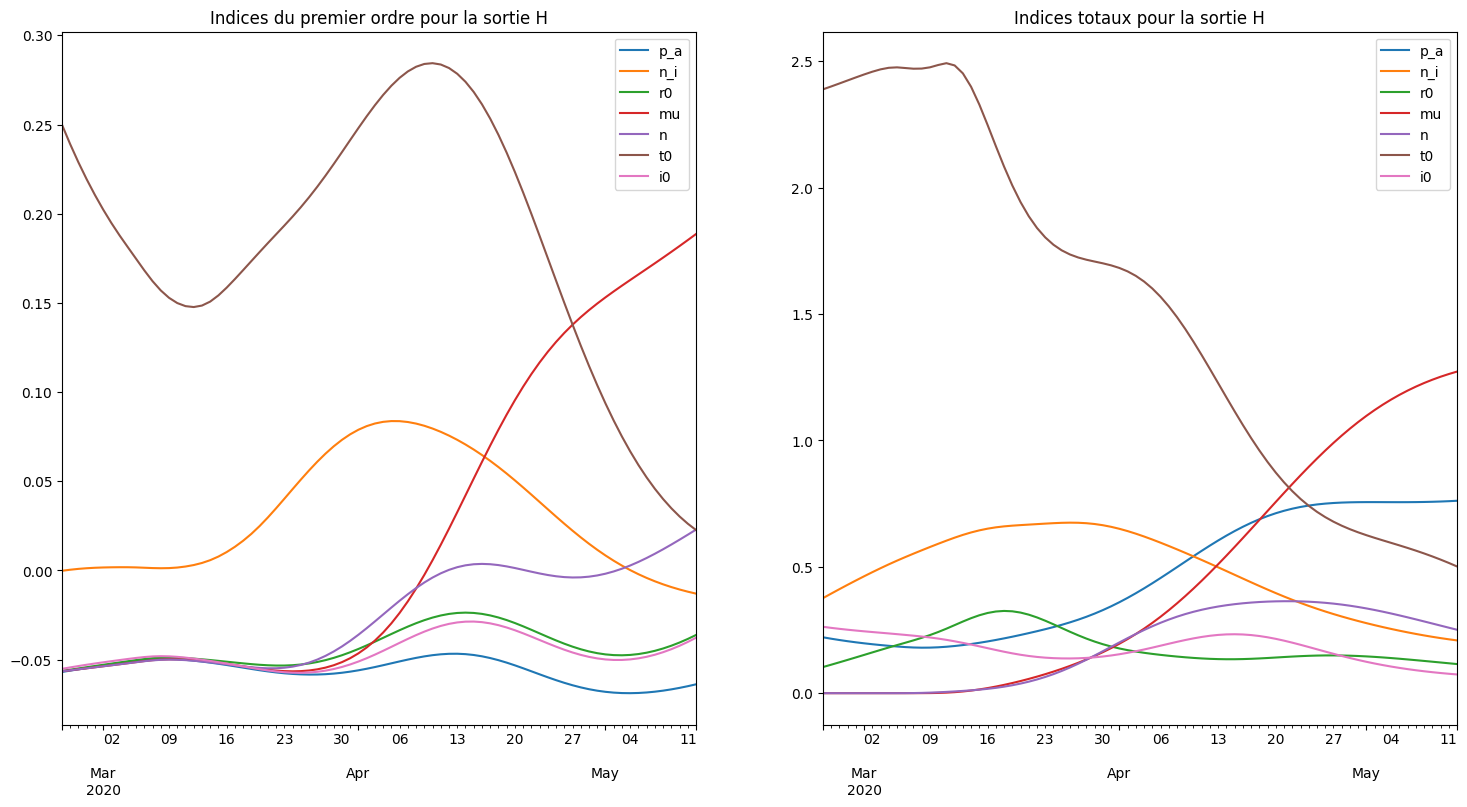

In [55]:
fig , (ax1 , ax2) = plt.subplots(1 , 2 , figsize = (18,9))
df_fo.plot(ax = ax1)
ax1.title.set_text('Indices du premier ordre pour la sortie H')
df_tot.plot(ax = ax2)
ax2.title.set_text('Indices totaux pour la sortie H')
plt.show()

### Sortie U

In [56]:
Y_out , Ys_out , Ysp_out = calculate_Y(variable = 'U')

  0%|          | 0/100 [00:00<?, ?it/s]

In [57]:
times = list(range(len(Y_out[0])))
res_fo = [calculate_sobol(t ,Y_out , Ys_out , Ysp_out)[0] for t in times]
res_tot = [calculate_sobol(t , Y_out , Ys_out , Ysp_out)[1] for t in times]
df_fo = pd.DataFrame(res_fo , index = date_index , columns = variables)[parameters]
df_tot = pd.DataFrame(res_tot , index = date_index , columns = variables)[parameters]

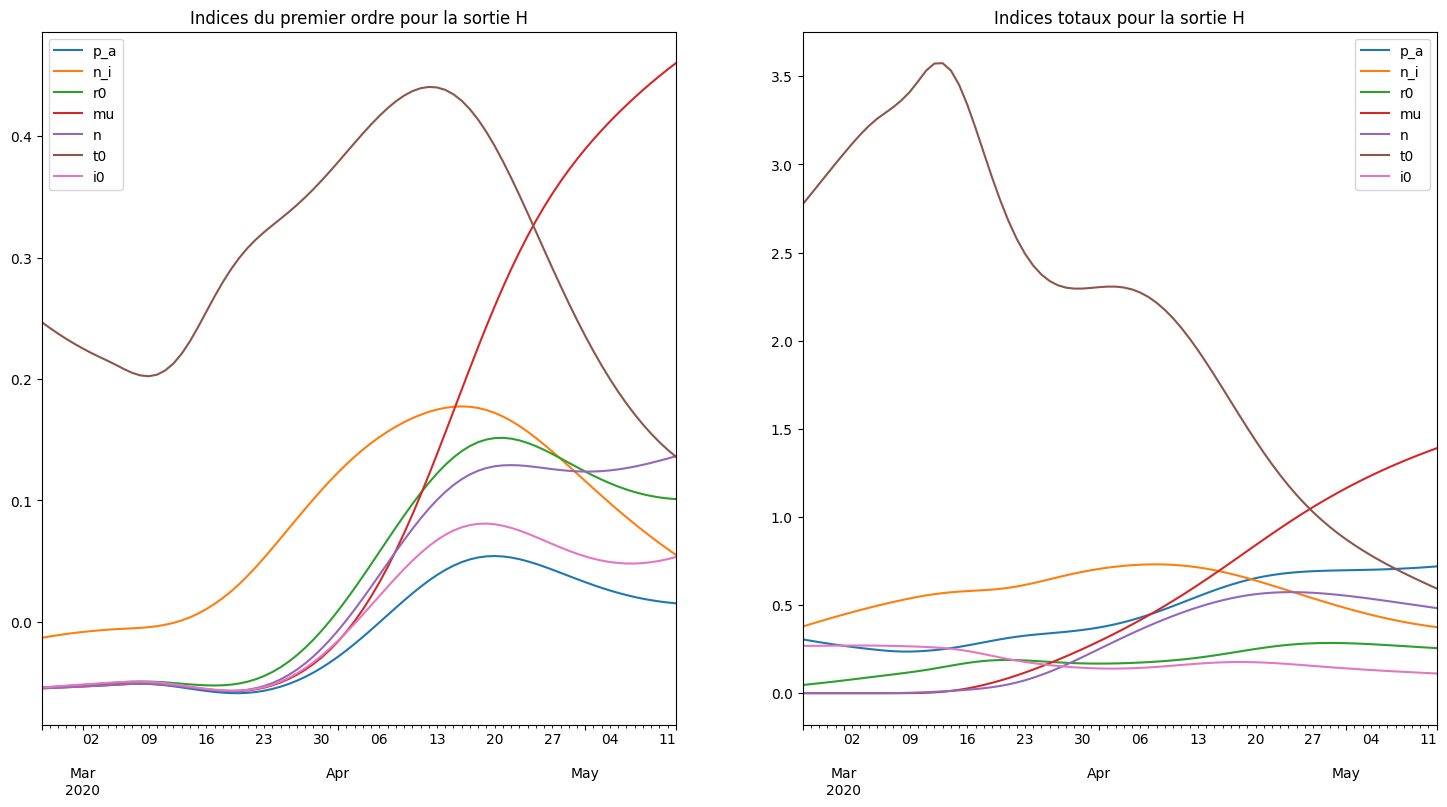

In [58]:
fig , (ax1 , ax2) = plt.subplots(1 , 2 , figsize = (18,9))
df_fo.plot(ax = ax1)
ax1.title.set_text('Indices du premier ordre pour la sortie H')
df_tot.plot(ax = ax2)
ax2.title.set_text('Indices totaux pour la sortie H')
plt.show()

### Sortie D

In [59]:
Y_out , Ys_out , Ysp_out = calculate_Y(variable = 'D')
times = list(range(len(Y_out[0])))
res_fo = [calculate_sobol(t ,Y_out , Ys_out , Ysp_out)[0] for t in times]
res_tot = [calculate_sobol(t , Y_out , Ys_out , Ysp_out)[1] for t in times]
df_fo = pd.DataFrame(res_fo , index = date_index , columns = variables)[parameters]
df_tot = pd.DataFrame(res_tot , index = date_index , columns = variables)[parameters]

  0%|          | 0/100 [00:00<?, ?it/s]

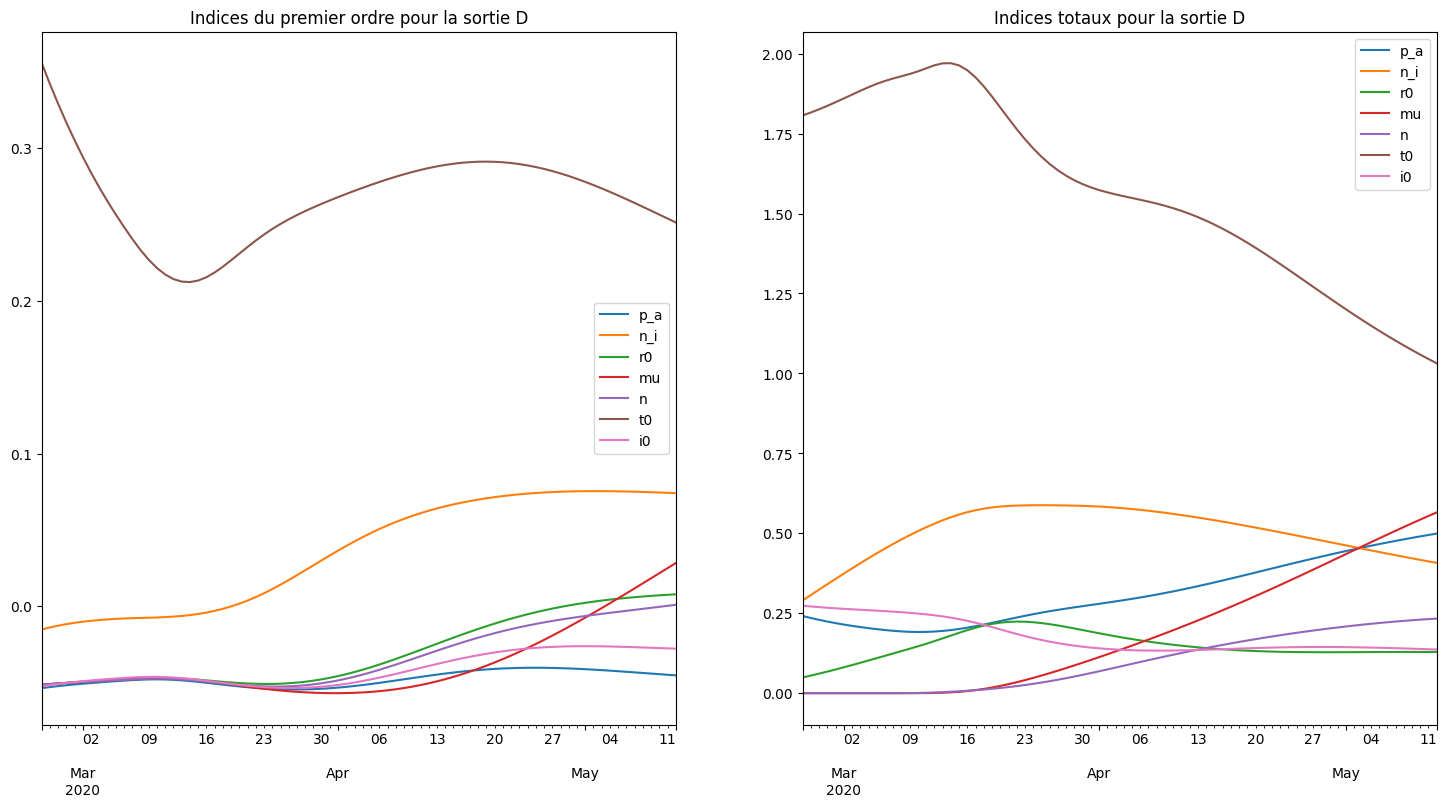

In [60]:
fig , (ax1 , ax2) = plt.subplots(1 , 2 , figsize = (18,9))
df_fo.plot(ax = ax1)
ax1.title.set_text('Indices du premier ordre pour la sortie D')
df_tot.plot(ax = ax2)
ax2.title.set_text('Indices totaux pour la sortie D')
plt.show()

### Sortie $R^{+H}$

In [61]:
Y_out , Ys_out , Ysp_out = calculate_Y(variable = 'RpH')
times = list(range(len(Y_out[0])))
res_fo = [calculate_sobol(t ,Y_out , Ys_out , Ysp_out)[0] for t in times]
res_tot = [calculate_sobol(t , Y_out , Ys_out , Ysp_out)[1] for t in times]
df_fo = pd.DataFrame(res_fo , index = date_index , columns = variables)[parameters]
df_tot = pd.DataFrame(res_tot , index = date_index , columns = variables)[parameters]

  0%|          | 0/100 [00:00<?, ?it/s]

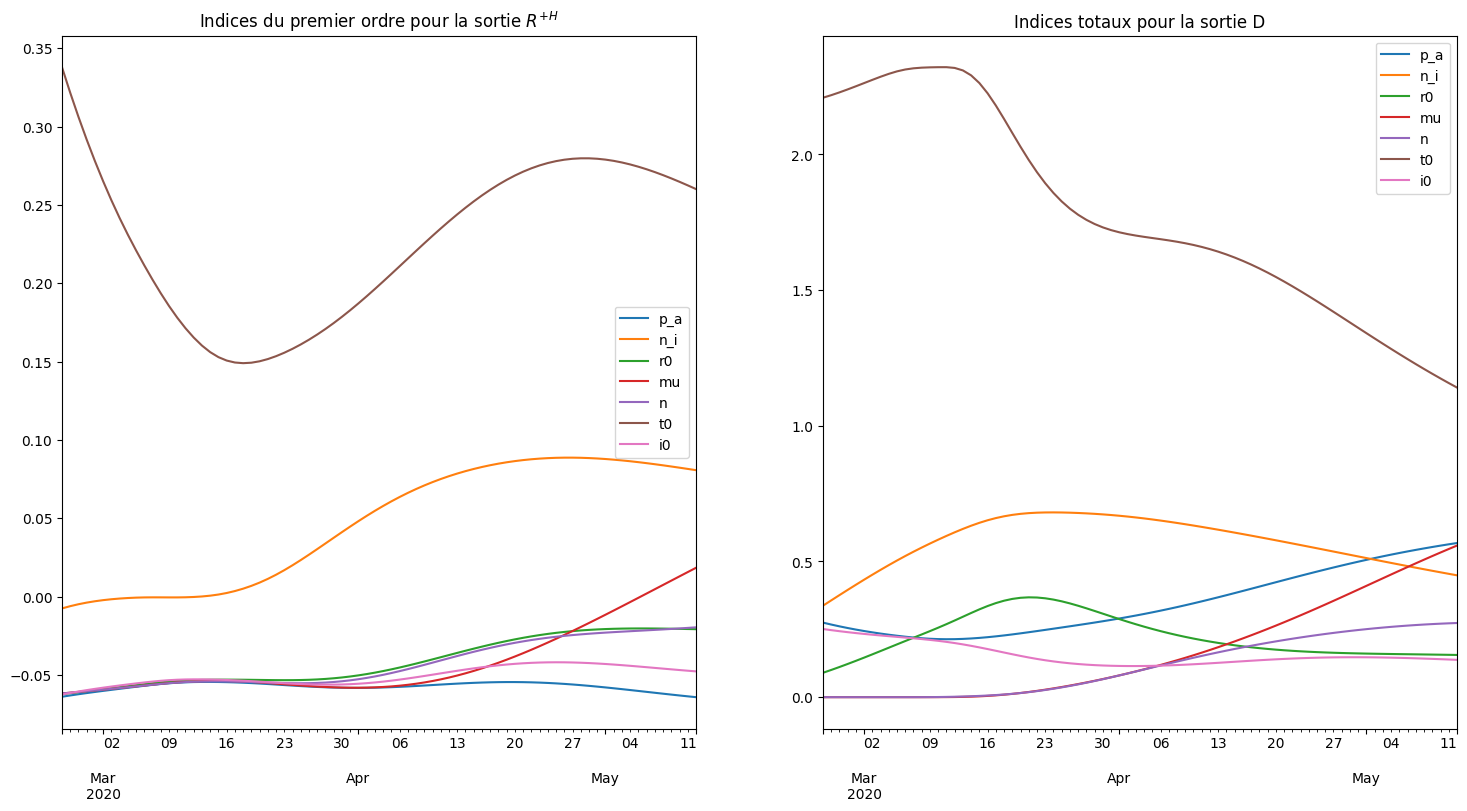

In [62]:
fig , (ax1 , ax2) = plt.subplots(1 , 2 , figsize = (18,9))
df_fo.plot(ax = ax1)
ax1.title.set_text('Indices du premier ordre pour la sortie $R^{+H}$')
df_tot.plot(ax = ax2)
ax2.title.set_text('Indices totaux pour la sortie D')
plt.show()

# Calibration

Effectuons à présent de la calibration, recherchons les paramètres pour lesquels le modèle est le plus en adéquation avec les données réelles. Commençons d'abord par charger et préparer les données depuis les adresses https://www.eficiens.com/coronavirus-statistiques/ et https://www.data.gouv.fr/fr/organizations/sante-publique-france/

,nbre
2020-05-07,629.0
2020-05-08,642.0
2020-05-09,433.0
2020-05-10,209.0
2020-05-11,456.0


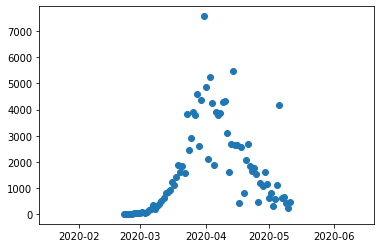

In [ ]:
#Préparation des données pour la quantité DR (nombre de cas journaliers)

cumulative = pd.read_csv('cumul.csv' , parse_dates = ['date'])
cumulative = cumulative.set_index('date')[:'11/05']
DR = cumulative
DR.nbre = DR.nbre - DR.nbre.shift(1)
DR = DR.dropna()
DR.index = pd.date_range('2020/2/22' , '2020/5/11')
plt.scatter(DR.index , DR.values)
DR.tail()

In [ ]:
#Préparation des données pour les autres sorties :
df = pd.read_csv('donnees.csv' , ';' , parse_dates = ['jour'])
df = df.groupby('jour')['hosp' , 'rea' , 'rad' , 'dc'].apply(sum)
df = df.rename(columns = {'hosp' : 'H' , 'rea' : 'U' , 'rad' : 'R' , 'dc' : 'D'})[:'2020-05-11']

In [ ]:
df.head()

,H,U,R,D
jour,,,,
2020-03-18,5905,1535,1627,435
2020-03-19,7961,1975,2322,642
2020-03-20,10272,2564,3128,890
2020-03-21,11599,2872,3580,1041
2020-03-22,13675,3311,4188,1251


Traçons les données ainsi obtenues :

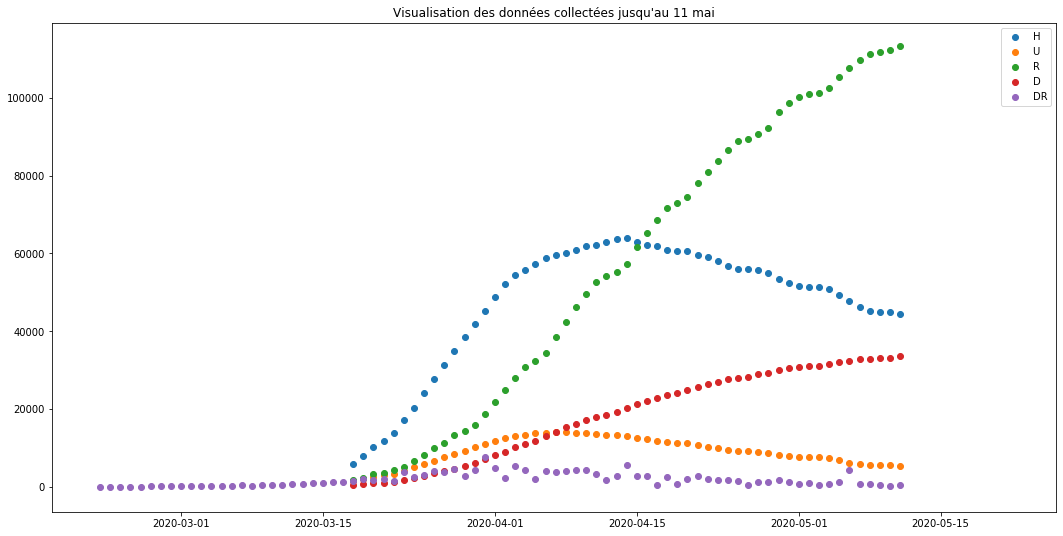

In [ ]:
plt.figure(figsize = (18,9))
for feat in ['H' , 'U' , 'R' , 'D']:
    plt.scatter(df.index , df[feat] , label = feat)

plt.scatter(DR.index , DR.values , label = 'DR')
plt.legend()
plt.title("Visualisation des données collectées jusqu'au 11 mai")
plt.show()

## Calibration déterministe

In [ ]:
t_18mars = (pd.to_datetime('2020-03-18') - datetime(2020 , 1 , 25)).days
t_31mars = (pd.to_datetime('2020-03-31') - datetime(2020 , 1 , 25)).days
t_25fev = (pd.to_datetime('2020-02-25') - datetime(2020 , 1 , 25)).days
t_11mai = (pd.to_datetime('2020-05-11') - datetime(2020 , 1 , 25)).days

In [ ]:
data_DR = DR['2020-2-25':].values
data_DR = data_DR.reshape(len(data_DR))
data = df[:'2020-03-31'].values

In [ ]:
def f_out(params): #Fonction qui prend en entrée une réalisation des paramètres et renvoie la solution du système d'ED

    p_a , p_ih , p_iu , p_hd , p_hu , p_ud , n_i , n_h , n_u , r0 , mu , n , t0 , i0 , l1 = tuple(params)
    g_IR , g_IH , g_IU , g_HD , g_HU , g_HR , g_UD , g_UR , S0 , tau0, Y0 = prepare_pars(p_a , p_ih , p_iu , p_hd , p_hu , p_ud , n_i , n_h , n_u , r0 , mu , n , t0 , i0 , l1 , l2)
    args = (l1 , l2 , g_IR , g_IH , g_IU , g_HD , g_HU , g_HR , g_UD , g_UR , tau0 , n , mu)

    solution = solve_ivp(lambda t,y : systeme(t , y , *args), [t0, t0 + 120] , Y0, max_step=1)

    return int(t0) , solution.y

def f_var(x , out , t0 ,  index , data = data): #Calcul des résidus

    M_var = out[index]
    M_var = M_var[t_18mars - t0 : t_31mars - t0 + 1]
    data = data[: , index - 5]

    return (M_var - data)/np.sqrt(M_var)


def f_DR(x , out , t0 , DR = data_DR): #Calcul des résidus pour DR
    M_DR = out[-1]
    M_DR = M_DR[t_25fev - t0 : t_11mai - t0 + 1]

    return (M_DR - data_DR)/np.sqrt(M_DR)

In [ ]:
def epsilon(x , DR = data_DR , data = data): #Définition de la fonction des moindres carrés à minimiser

    t0 , out = f_out(x)
    f_dr = f_DR(x , out , t0)
    f_h = f_var(x , out , t0 ,index = 5)
    f_u = f_var(x , out , t0 , index = 6)
    f_d = f_var(x , out , t0 , index = 8)
    f_r = f_var(x , out , t0 , index = 7)
    return (f_dr**2).sum() + (f_h**2 + f_u**2 + f_d**2 + f_r**2).sum()

In [ ]:
from scipy.optimize import minimize, Bounds

In [ ]:
#Définition des bornes pour la minimisation :

lb = [0.4, 0.05, 0.01, 0.1, 0.1, 0.2, 8, 15, 10, 2.9, 0.01, 30, 0, 1, 0.001]
ub = [0.9, 0.2, 0.04, 0.2, 0.2, 0.4, 12, 25, 20, 3.4, 0.08, 50, 30, 100, 0.01]
bounds = Bounds(lb , ub)

Pour limiter les risques d'attérir dans un minimum local, on tire un certain nombre de fois des paramètres initiaux pour lancer l'optimisation et on conserve le résultat donnant l'epsilon le plus petit. Ici, on choisit d'effectuer la minimisation 50 fois

In [ ]:
best = 1e10
best_x = np.zeros(16)
for i in range(50):
    x0 = get_params()[:-1]
    results = minimize(epsilon , x0 = x0 , bounds = bounds, options={'disp': True})
    if results.fun < best:
        best = results.fun
        best_x = results.x

In [ ]:
best

49754.99226616351

In [ ]:
x = best_x

In [ ]:
t0 , M_DR = f_out(x)
M_DR = M_DR[-1]
M_DR = M_DR[t_25fev - t0 : t_11mai - t0 + 1]

On trace à présent le résultat obtenu pour le $x^*$ obtenu par la minimisation que l'on compare aux données réelles

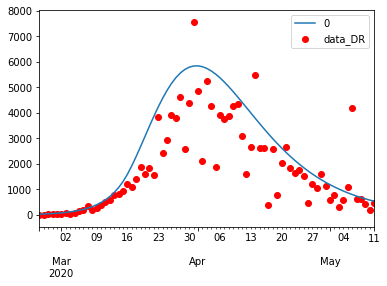

In [ ]:
date = pd.date_range('2020-02-25' , '2020-05-11')
pd.DataFrame(np.array([M_DR]).T , index = date).plot(label = 'M_DR')
dd = pd.DataFrame(np.array([data_DR]).T , index = date)
plt.scatter(date , dd , label = 'data_DR' , color = 'red')
plt.legend()
plt.show()

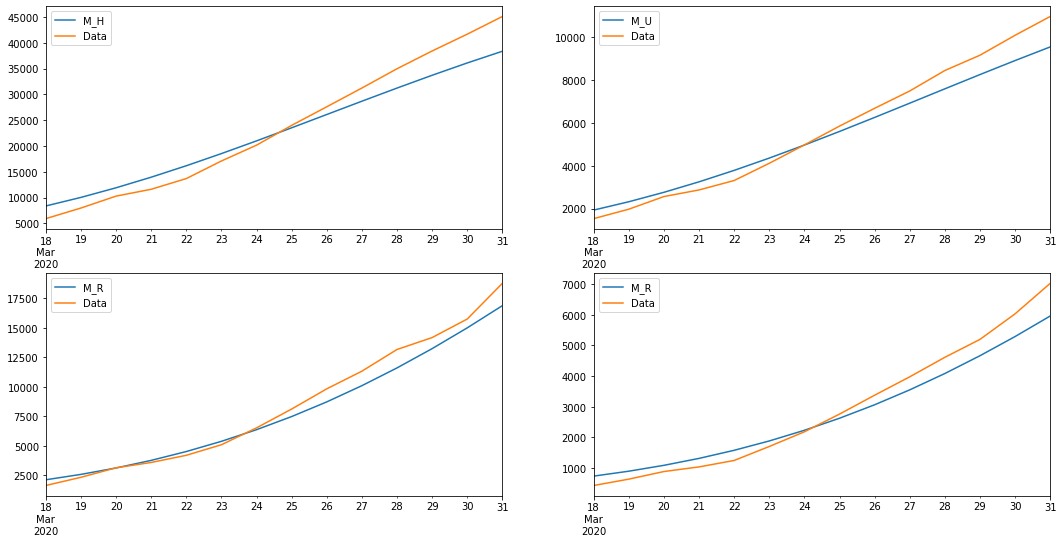

In [ ]:
fig , ((ax1 , ax2) , (ax3 , ax4)) = plt.subplots(2 , 2 , figsize = (18,9))
t0 , M = f_out(x)

M_H = M[5]
M_H = M_H[t_18mars - t0 : t_31mars - t0 + 1]
data_H = data[: , 0]
date = pd.date_range('2020-03-18' , '2020-03-31')
pd.DataFrame(np.array([M_H , data_H]).T , columns = ['M_H' , 'Data'] , index = date).plot(ax = ax1)


M_U = M[6]
M_U = M_U[t_18mars - t0 : t_31mars - t0 + 1]
data_U = data[: , 1]
date = pd.date_range('2020-03-18' , '2020-03-31')
pd.DataFrame(np.array([M_U , data_U]).T , columns = ['M_U' , 'Data'] , index = date).plot(ax = ax2)


M_R = M[7]
M_R = M_R[t_18mars - t0 : t_31mars - t0 + 1]
data_R = data[: , 2]
date = pd.date_range('2020-03-18' , '2020-03-31')
pd.DataFrame(np.array([M_R , data_R]).T , columns = ['M_R' , 'Data'] , index = date).plot(ax = ax3)

M_D = M[8]
M_D = M_D[t_18mars - t0 : t_31mars - t0 + 1]
data_D = data[: , 3]
date = pd.date_range('2020-03-18' , '2020-03-31')
pd.DataFrame(np.array([M_D , data_D]).T , columns = ['M_R' , 'Data'] , index = date).plot(ax = ax4)

# Calibration Bayésienne

## Question 8 :

$$\mathcal{L} = \ln(p(data|x,\sigma)) = -(n_{DR}/2 + 2n_H)*\ln(2\pi) - (n_{DR}\ln(\sigma_{DR}) + n_{H}(\ln(\sigma_{H}) + \ln(\sigma_{U}) + \ln(\sigma_{D}) + \ln(\sigma_{R}))) \\- \frac{1}{2}\sum_{i=1}^{n_{DR}}\frac{f_{DR}(x,s_i)^2}{\sigma_{DR}^2} - \frac{1}{2}\sum_{i=1}^{n_{H}}\frac{f_{H}(x,t_i)^2}{\sigma_{H}^2} + \frac{f_{U}(x,t_i)^2}{\sigma_{U}^2} + \frac{f_{D}(x,t_i)^2}{\sigma_{D}^2} + \frac{f_{R}(x,t_i)^2}{\sigma_{R}^2}$$

On obtient alors :
$$\frac{\partial \mathcal{L}}{\partial \sigma_{DR}} = -\frac{n_{DR}}{\sigma_{DR}} + \frac{1}{\sigma_{DR}^3}\sum_{i=1}^{n_{DR}}f_{DR}(x,s_i)^2 = 0 \iff (\sigma_{DR}^*)^2 = \frac{1}{n_{DR}}\sum_{i=1}^{n_{DR}}f_{DR}(x,s_i)^2$$

Le même calcul nous donne le résultat pour $\sigma_C^*$ , avec $C \in \{H , U , D , R\} $

## Question 9 :

En utilisant le théorème de Bayes :
$p(x|data) = \frac{p(data|x)p(x)}{p(data)} \propto p(data|x)p_0(x)$, où $p(data|x)$ et $p_0(x)$ sont connues.

## Question 10 :

In [ ]:
def f_i(x_i , lb , ub): #denisté d'une loi uniforme dans [lb , ub]
    if x_i >= lb and x_i <= ub:
        return 1/(ub-lb)
    else:
        return 0

In [ ]:
lower_bounds = [0.4, 0.05, 0.01, 0.1, 0.1, 0.2, 8, 15, 10, 2.9, 0.01, 30, 0, 1, 0.001]
upper_bounds = [0.9, 0.2, 0.04, 0.2, 0.2, 0.4, 12, 25, 20, 3.4, 0.08, 50, 30, 100, 0.01]

In [ ]:
def p0(x): #définition de la densité d'une loi uniforme multidimensionnelle sur les bornes des paramètres
    res = 1
    bounds = zip(lower_bounds , upper_bounds)
    for x_i , (lb , ub) in zip(tuple(x[:-1]) , bounds):
        res*=f_i(x_i , lb , ub)
    return res

In [ ]:
n_H = len(data)
n_DR = len(data_DR)

In [ ]:
def p_data(x): #Définition de p(data|x) en prenant le sigma optimal trouvé à la question 8

    t0 , out = f_out(x)

    f_dr = np.array(f_DR(x , out , t0))
    f_h = np.array(f_var(x , out , t0 ,index = 5))
    f_u = np.array(f_var(x , out , t0 , index = 6))
    f_d = np.array(f_var(x , out , t0 , index = 8))
    f_r = np.array(f_var(x , out , t0 , index = 7))

    s_DR = np.sqrt(1/n_DR*sum(f_dr**2)) #Sigmas optimaux
    s_H = np.sqrt(1/n_H*sum(f_h**2))
    s_U = np.sqrt(1/n_H*sum(f_u**2))
    s_D = np.sqrt(1/n_H*sum(f_d**2))
    s_R = np.sqrt(1/n_H*sum(f_r**2))



    term1 = (2*np.pi)**(-n_DR/2 - 2*n_H)*s_DR**(-n_DR)*(s_H*s_U*s_D*s_R)**(-n_H)
    term2 = np.exp(-1/2*np.sum(f_dr**2/s_DR**2) - 1/2*np.sum(f_h**2/s_H**2 + f_u**2/s_U**2 + f_d**2/s_D**2 + f_r**2/s_R**2))
    return term1*term2


## Algorithme de Metropolis-Hastings

In [ ]:
x0 = best_x
Xs = [x0]
sigma = 0.05 #On fixe sigma de manière à avoir un nombre satisfaisant de propositions acceptées
x = x0
for i in range(100):
    X_prime = np.random.normal(x0 , sigma)
    rho = p_data(X_prime)*p0(X_prime)/(p_data(x0)*p0(x0))
    a = min(1 , rho) #on calcule le taux d'acceptation a
    u = np.random.random() #On tire une loi uniforme
    if u <= a :
        Xs.append(X_prime)
        x = X_prime

Affichons les lois a priori et a posteriori de chacun des paramètres :

In [ ]:
Xs = np.array(Xs)
Xs_prior = np.array([get_params() for i in range(len(Xs))])
plt.subplots(4 , 4 , figsize = (25,12))
for i in range(15):
    ax = plt.subplot(4 , 4 , i+1)
    ax.set_title(variables[i])
    sns.distplot(Xs_prior[: , i] , label = 'a priori')
    sns.distplot(Xs[: , i] , label = 'a posteriori')
    plt.legend()

On remarque que pour certaines variables (notamment les variables prenant des valeurs entières ou $p_a$), l'incertitude est très fortement réduite là où ce n'est pas le cas pour $n_i$ ou $\mu$ par exemple.

## Matrices de corrélation a priori et a posteriori

In [ ]:
sns.heatmap(pd.DataFrame(Xs_prior[: , : -1] , columns = variables[:-1]).corr())

In [ ]:
sns.heatmap(pd.DataFrame(Xs , columns = variables[:-1]).corr())

## Prédictions

La calibration a été effectuée en se basant sur les données jusqu'au 31 mars, effectuons des prédictions avec les paramètres obtenus par calibration

In [ ]:
p_a , p_ih , p_iu , p_hd , p_hu , p_ud , n_i , n_h , n_u , r0 , mu , n , t0 , i0 , l1 = best_x

g_IR , g_IH , g_IU , g_HD , g_HU , g_HR , g_UD , g_UR , S0 , tau0, Y0 = prepare_pars(p_a , p_ih , p_iu , p_hd , p_hu , p_ud , n_i , n_h , n_u , r0 , mu , n , t0 , i0 , l1 , 0)

args = (l1 , l2 , g_IR , g_IH , g_IU , g_HD , g_HU , g_HR , g_UD , g_UR , tau0 , n , mu)

In [ ]:
solution = solve_ivp(lambda t,y : systeme(t , y , *args) , [int(t0), int(t0) + 130], Y0,  method='RK45' , max_step = 1 )

In [ ]:
columns = ['S' , 'Im' , 'Ip' , 'Rm' , 'RpI' , 'H' , 'U' , 'RpH' , 'D' , 'DR']
results = pd.DataFrame(solution.y.T , columns = columns)
t0 = datetime(day = 25 , month = 1 , year = 2020) + timedelta(days = int(t0))
N = datetime(day = 24 , month = 2 , year = 2020) + timedelta(days = n)
index = pd.date_range(start = t0 ,  periods=len(results)).date
results.index = index

Text(0.5, 1.0, 'Prédictions entre le 1er avril et le 11 mai')

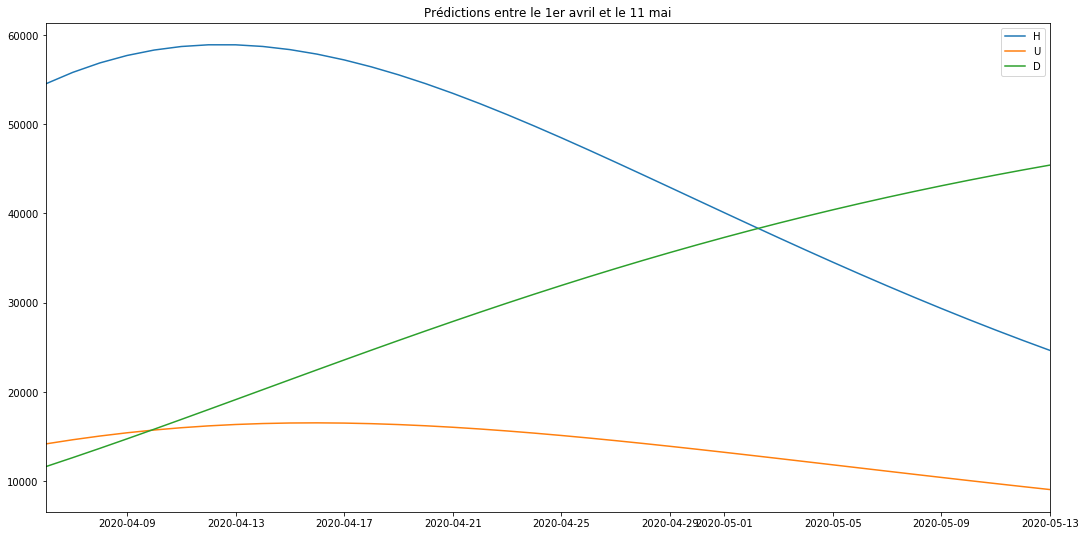

In [ ]:
results[['H' , 'U' , 'D']].iloc[67:105].plot(figsize = (18,9))
plt.title('Prédictions entre le 1er avril et le 11 mai')